### **Problem Statement**: 

- Given an image of a t-shirt, classify it into one of the following two categories:
  1. Plain (solid) t-shirt or
  2. Typography t-shirt (contains text)
  
- This is a binary classification problem.

- The same concepts can be applied to any other binary classification problem.

- With some minor modifications, the same code and process can be expanded to multi-category or even multi-label problems (we won't be covering them here).

- We will be leveraging techniques such as Deep Learning, which is a subfield within Machine Learning, Convolutional Neural Networks (CNNs), and Transfer Learning.

- We will also explore some regularization topics such as Image Augmentation and Dropout.

- At a high level, we will follow this structure in the code:
  1. Importing libraries
  2. Importing and examining data
  3. Training the model
     - We will explore different Deep Learning architectures, parameters, and hyperparameters.
  4. Evaluating the model
  5. Examining the metrics and plots

---


# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing libraries
import os
import pandas as pd
import tensorflow as tf
import tensorflow.keras.models as models

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import metrics

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

# Input Data

### Paths

In [ ]:
# Path to the directory containing training images
train_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/train"

# Path to the directory containing validation images
validation_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/valid"


### Train and validation image data generator

- We also implement image augumentation for training images. This will help reduce overfitting

In [ ]:
# Training ImageDataGenerator class with various augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255.,               # Rescale pixel values to a range of [0, 1]
    rotation_range=40,            # Randomly rotate the image up to 40 degrees
    width_shift_range=0.2,        # Randomly shift the image horizontally by up to 20% of its width
    height_shift_range=0.2,       # Randomly shift the image vertically by up to 20% of its height
    shear_range=0.2,              # Apply shear-based transformations to the image
    zoom_range=0.2,               # Randomly zoom in/out on the image by up to 20%
    horizontal_flip=True          # Randomly flip the image horizontally
)


In [ ]:
# Defining batch size and the image shape and specifying the source path
# The labels are automatically built from the folder name in the directory

train_generator = train_datagen.flow_from_directory(
    train_data_path,          # Path to the training data directory
    batch_size=32,            # Batch size for training
    class_mode='binary',      # Type of labels; binary classification
    target_size=(150, 150),   # Target image shape (height, width)
    seed=99                   # Random seed for reproducibility
)


Found 607 images belonging to 2 classes.


In [ ]:
# Validation ImageDataGenerator class with only the 'rescale' parameter.
# All other augmentation parameters are kept at their default values.

validation_datagen = ImageDataGenerator(
    rescale=1./255.  # Rescale the pixel values to be in the [0, 1] range
)


In [ ]:
# Defining a validation data generator for loading images from the specified directory.

# The generator is created using the validation ImageDataGenerator defined earlier.
validation_generator = validation_datagen.flow_from_directory(
    validation_data_path,  # Path to the directory containing validation images
    shuffle=False,          # Disable shuffling to maintain order
    batch_size=32,          # Batch size for loading images
    class_mode='binary',    # Specifies binary classification task
    target_size=(150, 150)  # Resizes images to 150x150 pixels
)


Found 152 images belonging to 2 classes.


In [ ]:
# Creating a DataFrame to store file paths and corresponding labels.

training_data_df = pd.DataFrame(data={
    "file": train_generator.filepaths,  # File paths for training images
    "labels": train_generator.labels     # Corresponding labels for the images
})


In [ ]:
training_data_df.sample()

,file,labels
223,/content/drive/MyDrive/colab_projects/image-cl...,0


---

### Visualizing training data

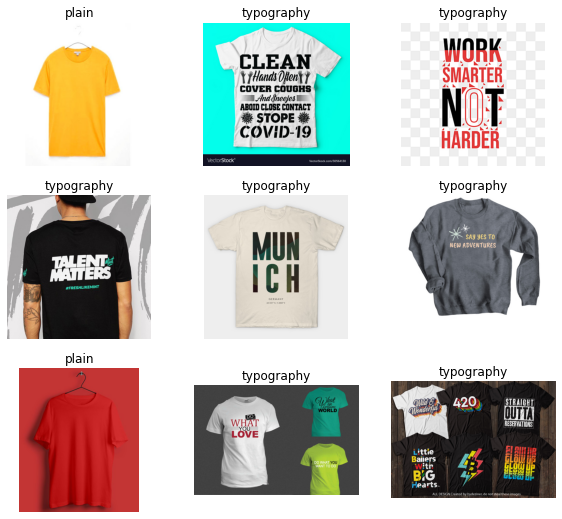

In [ ]:
# Visualizing a random sample of training data

# Sample 10 random rows from the 'training_data_df' DataFrame
sample_training_data = training_data_df.sample(10)

# Reset the index of the sample DataFrame
sample_training_data.reset_index(drop=True, inplace=True)

# Define a label mapping to map numeric labels to their corresponding class names
label_mapping = {0: "plain", 1: "typography"}

# Create a figure for displaying the images and labels
plt.figure(figsize=(10, 9))

# Loop through the 9 images in the sample
for i in range(9):
    plt.subplot(3, 3, i + 1)  # Create a subplot in a 3x3 grid
    plt.imshow(mpimg.imread(sample_training_data.iloc[i]['file']))  # Display the image
    plt.title(label_mapping[sample_training_data.iloc[i]['labels']])  # Set the title to the class name
    plt.axis("off")  # Turn off axis labels and ticks


---

# Model Training

## Deep Learning and Convolutions

1. Deep learning because we don't need to handcraft features unlike other machine learning techniques.

2. Deep learning for Computer Vision is further improved by the use of convolutions.

3. Models like [VGG-16](https://arxiv.org/pdf/1409.1556.pdf), [MobileNet](https://arxiv.org/pdf/1704.04861.pdf), and [Inception](https://arxiv.org/pdf/1409.4842.pdf) have become increasingly popular in solving a wide variety of problems, achieving state-of-the-art results.

### Hyperparameters to Tune:

- Learning Rate
- Dropout Fraction
- Number of Fully Connected Layers & Number of Nodes in Each Layer

### Transfer Learning

- Resnet
- Inception
- Training Only the Newly Added Layers


In [ ]:
# Import the necessary module for InceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3

def get_pre_trained_model_inception():

    try:
        # Download the model weights (if needed) - you can use the provided wget command if required
        # weights_filepath = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
        
        # Initialize the pre-trained model (InceptionV3)
        model = InceptionV3(
            include_top=False,  # Exclude the fully connected layers (top)
            input_shape=(150, 150, 3),  # Input shape of your images
            weights='imagenet'  # Initialize with pre-trained weights from ImageNet
        )
        
        # Load custom weights if available
        # model.load_weights(weights_filepath)
        
    except:
        print("Initializing pre-trained model failed !!")

    # Freeze the weights of the pre-trained layers to prevent updates during training
    for layer in model.layers:
        layer.trainable = False

    # Get the output of the last layer in the model
    last_layer = model.get_layer("mixed7")
    last_output = last_layer.output

    return model, last_output


In [ ]:
# Import the necessary module for ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50

def get_pre_trained_model_resnet():

    # Initialize the pre-trained model (ResNet50)
    model = ResNet50(
        include_top=False,  # Exclude the fully connected layers (top)
        weights='imagenet',  # Initialize with pre-trained weights from ImageNet
        input_shape=(150, 150, 3)  # Input shape of your images
    )

    # Freeze the weights of the pre-trained layers to prevent updates during training
    for layer in model.layers:
        layer.trainable = False

    # Get the output of the last layer in the model
    output = model.layers[-1].output

    return model, output


In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop

def get_optimizer(optimizer_name="adam", lr=0.0001):

    if optimizer_name == "adam":
        # Create an Adam optimizer with the specified learning rate
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == "rmsprop":
        # Create an RMSprop optimizer with the specified learning rate
        optimizer = RMSprop(learning_rate=lr)

    return optimizer


In [ ]:
def define_model(model="inception", learning_rate=0.000001):
    """
    Define and compile a neural network model.

    Parameters:
    - model: A string, either 'inception' or 'resnet' (default: 'inception').
    - learning_rate: Learning rate for the optimizer (default: 0.000001).

    Returns:
    - model: The compiled neural network model.
    """

    # Choose the base model (Inception or ResNet)
    if model == 'inception':
        base_model, last_output = get_pre_trained_model_inception()
    elif model == 'resnet':
        base_model, last_output = get_pre_trained_model_resnet()

    # Add custom layers on top of the pretrained model
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Dropout for regularization
    x = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid layer for binary classification

    model = models.Model(base_model.input, x)  # Create the final model

    # Get an optimizer with the specified learning rate
    optimizer = get_optimizer(lr=learning_rate)

    # Compile the model with binary cross-entropy loss and accuracy metric
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def get_callbacks():
    """
    Get a list of callback functions for model training.

    Returns:
    - callbacks: A list of callback functions.
    """
    # EarlyStopping callback to prevent overfitting
    es_callback = EarlyStopping(monitor='val_loss', patience=5)

    return [es_callback]


In [ ]:
def fit_model(model='inception', lr=0.000001):
    """
    Train a model using the specified architecture and learning rate.

    Args:
    - model (str): Model architecture ('inception' or 'resnet').
    - lr (float): Learning rate for optimization.

    Returns:
    - history: Training history.
    - model: Trained model.
    """
    # Define and compile the model
    model = define_model(model=model, learning_rate=lr)

    # Get callback functions
    callbacks = get_callbacks()

    # Train the model
    history = model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs=2,  # You can adjust the number of epochs
                        steps_per_epoch=None,
                        validation_steps=None,
                        verbose=1,
                        callbacks=callbacks)

    return history, model


In [ ]:
# Fit the model and obtain the training history and the trained model
history, model = fit_model()


Epoch 1/2
 5/19 [======>.......................] - ETA: 18s - loss: 0.7347 - accuracy: 0.4500

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 38s 1s/step - loss: 0.7024 - accuracy: 0.5222 - val_loss: 0.6706 - val_accuracy: 0.6250
Epoch 2/2
19/19 [==============================] - 17s 921ms/step - loss: 0.6363 - accuracy: 0.6705 - val_loss: 0.6272 - val_accuracy: 0.7303


In [ ]:
# Saving the trained model to an HDF5 file
model.save("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5", save_format="h5")


In [ ]:
# Load the pre-trained model from a file
model = tf.keras.models.load_model("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5")


---

### Training plots

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(history, metrics=['loss', 'binary_accuracy']):
    # Calculate the number of metrics to plot
    num_metrics = len(metrics)

    # Create a figure with subplots for each metric
    plt.figure(figsize=(10, 9))
    for i, metric in enumerate(metrics):
        epochs = range(1, (len(history[metric]) + 1))
        plt.subplot(num_metrics, 1, (i + 1))

        # Plot the training and validation data for the metric
        plt.plot(epochs, history[metric], label='training_' + metric)
        plt.plot(epochs, history['val_' + metric], label='validation_' + metric)

        # Set title and labels
        plt.title("Training and validation " + metric)
        plt.ylabel(metric)
        plt.xlabel('epochs')

        # Add a legend
        plt.legend()

        # Show the plot (use plt.savefig() to save it to a file)
        plt.show()
    
    # Close the figure
    plt.close()


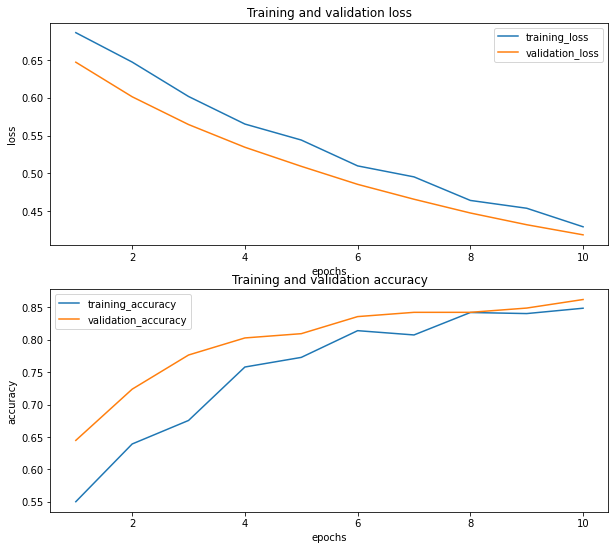

In [ ]:
# Plot 'loss' and 'accuracy' metrics from the 'history' dictionary
plot_metrics(history.history, metrics=['loss', 'accuracy'])

In [ ]:
# plt.savefig("output/plt1.jpeg")

---

# Model Testing

## 1. What is Testing?

Testing is the process of evaluating the performance of a machine learning model using a set of data that it hasn't seen during training. This data, often referred to as the test dataset, is used to assess how well the model generalizes to new, unseen examples.

## 2. Why Model Testing is Important?

Model testing is crucial for several reasons:
- It provides an estimate of how well the model is expected to perform on new, real-world data.
- It helps identify potential issues like overfitting or underfitting.
- It allows for fine-tuning and improvement of the model before deployment.
- It instills confidence in the model's reliability and effectiveness.

## 3. How Do We Do It?

Model testing involves:
- Using a separate dataset (the test dataset) that the model hasn't been exposed to during training.
- Feeding the test dataset to the model for predictions.
- Comparing the model's predictions to the actual target values in the test dataset.

## 4. Which Metrics are Important?

### a. Precision

Precision measures the model's ability to make accurate positive predictions. It is calculated as the ratio of true positives to the sum of true positives and false positives. High precision indicates a low rate of false positives.

### b. Recall

Recall, also known as sensitivity or true positive rate, measures the model's ability to identify all relevant instances. It is calculated as the ratio of true positives to the sum of true positives and false negatives. High recall indicates a low rate of false negatives.

### c. F1-Score

The F1-Score is the harmonic mean of precision and recall. It provides a balance between these two metrics. It's particularly useful when you need to consider both false positives and false negatives.

### d. Accuracy

Accuracy measures the overall correctness of the model's predictions. It is calculated as the ratio of correct predictions to the total number of predictions. While accuracy is important, it may not be sufficient in imbalanced datasets.

### e. ROC-AUC

Receiver Operating Characteristic-Area Under the Curve (ROC-AUC) is used to evaluate the performance of binary classification models. It measures the ability to distinguish between the positive and negative classes. A higher ROC-AUC score indicates better model performance.



### Estimating test accuracy

In [ ]:
# Importing libraries
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [ ]:
# Define the path to the directory containing test data
test_data_path = "/content/drive/MyDrive/colab_projects/image-classification/input/images/test"

In [ ]:
# Load a pre-trained model from a specified file path
model = tf.keras.models.load_model("/content/drive/MyDrive/colab_projects/image-classification/output/models/inceptionV3_clf_model.h5")

In [ ]:
# Define a data generator for test data with image rescaling
test_datagen = ImageDataGenerator(rescale=1./255.)

# Create a test data generator by loading images from a directory
test_generator = test_datagen.flow_from_directory(test_data_path,
                                                  shuffle=False,  # Do not shuffle test data
                                                  batch_size=32,   # Batch size for predictions
                                                  class_mode='binary',  # Binary classification
                                                  target_size=(150, 150)  # Resize images to a common size
)


Found 100 images belonging to 2 classes.


In [ ]:
# Evaluate the trained model on the test data to get performance metrics
model_evaluation = model.evaluate(test_generator)

4/4 [==============================] - 4s 340ms/step - loss: 0.6321 - accuracy: 0.7200


In [ ]:
# Calculate and store the model evaluation metrics and their names as a dictionary
evaluation_metrics = dict(zip(model.metrics_names, model_evaluation))

# Print the evaluation metrics
print(evaluation_metrics)


{'loss': 0.6321064233779907, 'accuracy': 0.7200000286102295}


---

### Predictions

In [ ]:
# Generate predictions using the trained model on the test data
predictions = model.predict(test_generator)


In [ ]:
# Display the first 10 predictions
predictions[:10]

array([[0.36856234],
       [0.45017225],
       [0.40573493],
       [0.46506974],
       [0.45074317],
       [0.5388152 ],
       [0.31432018],
       [0.41660354],
       [0.49628657],
       [0.60023814]], dtype=float32)

In [ ]:
# Apply a threshold to the model's output probabilities to make binary predictions.
predictions = np.where(predictions > 0.5, 1, 0)


In [ ]:
predictions.reshape((100,))

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1])

In [ ]:
# Calculate the confusion matrix to evaluate model performance.
cm = confusion_matrix(test_generator.labels, predictions)


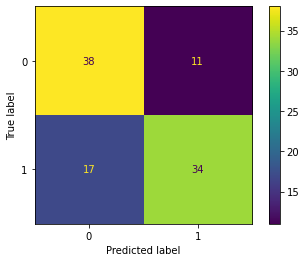

In [ ]:
# Reshape the predictions from a 2D array to a 1D array containing 100 elements
ConfusionMatrixDisplay.from_predictions(test_generator.labels, predictions)

In [ ]:
# Generate classification report
cr = classification_report(test_generator.labels, predictions, labels=[1,0])

In [ ]:
print(cr)

              precision    recall  f1-score   support

           1       0.76      0.67      0.71        51
           0       0.69      0.78      0.73        49

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100



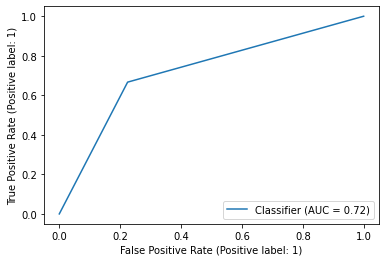

In [ ]:
# Display ROC curve
RocCurveDisplay.from_predictions(test_generator.labels, predictions)

---

### Analyzing incorrect predictions

In [ ]:
pred_vs_actuals_df = pd.DataFrame(data = {
    "actual_label": test_generator.labels,  # Column for actual labels from the test generator
    "pred_label": predictions.reshape(-1),  # Column for predicted labels from the 'predictions' array
    "file": test_generator.filepaths         # Column for file paths from the test generator
})


In [ ]:
# Create a DataFrame containing rows with prediction errors
pred_error_df = pred_vs_actuals_df[pred_vs_actuals_df.pred_label != pred_vs_actuals_df.actual_label]

# Sample 5 random rows from the DataFrame with prediction errors
pred_error_df = pred_error_df.sample(5)

# Reset the index of the sampled DataFrame and modify it in place
pred_error_df.reset_index(drop=False, inplace=True)


In [ ]:
pred_error_df.sample()

,index,actual_label,pred_label,file
1,89,1,0,/content/drive/MyDrive/colab_projects/image-cl...


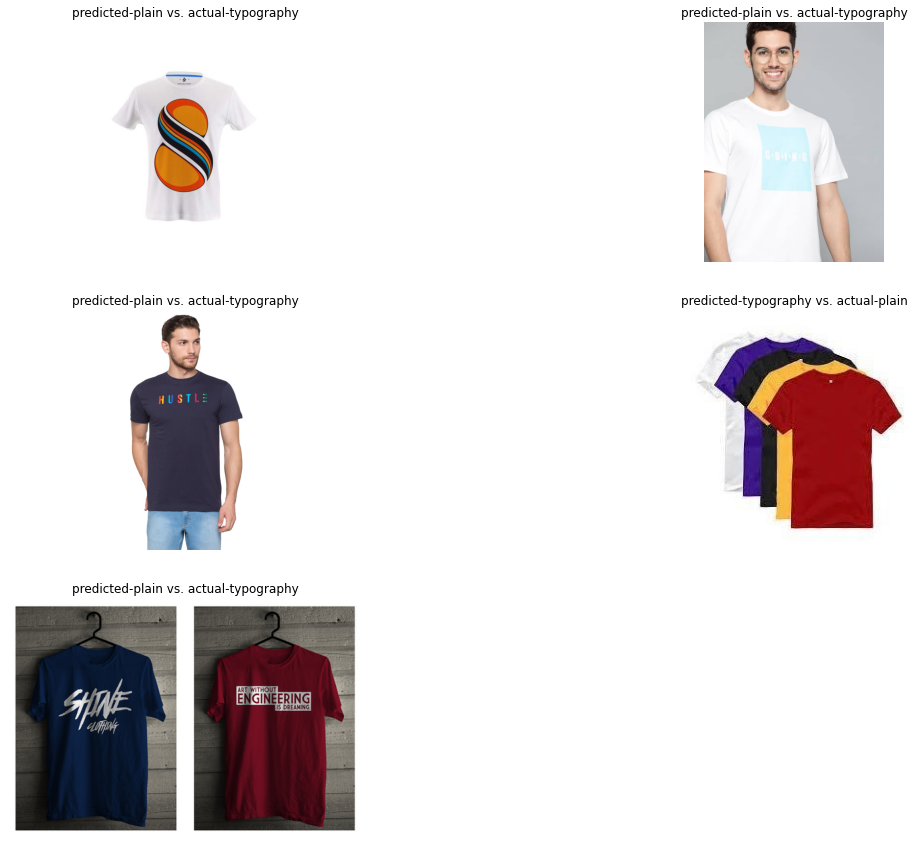

In [ ]:
## visualizing incorrect predictions

# Define a label mapping for class labels
label_mapping = {0: "plain", 1: "typography"}

# Create a figure for visualization
plt.figure(figsize=(20, 15))

# Iterate through incorrect predictions
for i in range(pred_error_df.shape[0]):
    # Create subplots in a grid
    plt.subplot(np.ceil(pred_error_df.shape[0] / 2), 2, i + 1)

    # Display the image
    plt.imshow(mpimg.imread(pred_error_df.iloc[i]['file']))

    # Set the title with predicted and actual labels
    plt.title("predicted-{} vs. actual-{}".format(
        label_mapping[pred_error_df.iloc[i]['pred_label']],
        label_mapping[pred_error_df.iloc[i]['actual_label']]
    ))

    # Turn off the axis
    plt.axis("off")

plt.show()


---

# Hyperparameter tuning

In [ ]:
# Parameter grid for hyperparameter tuning with learning rates
param_grid = {'learning_rate': [0.000001, 0.00001, 0.001]}


In [ ]:
# Loop through hyperparameter tuning for learning rates
for param in param_grid.keys():
    print("Tuning {}".format(param))
    if param == 'learning_rate':
        for lr in param_grid[param]:
            print("\n")
            print("\tTrying with {0}={1}".format(param, lr))
            # Call a function (e.g., fit_model) with the specified learning rate
            fit_model(lr=lr)


Tuning learning_rate


	Trying with learning_rate=1e-06
Epoch 1/2
 1/19 [>.............................] - ETA: 1:28 - loss: 0.7313 - accuracy: 0.6250

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


19/19 [==============================] - 24s 1s/step - loss: 0.6551 - accuracy: 0.6425 - val_loss: 0.6016 - val_accuracy: 0.7500
Epoch 2/2
19/19 [==============================] - 17s 919ms/step - loss: 0.6150 - accuracy: 0.6771 - val_loss: 0.5636 - val_accuracy: 0.8026


	Trying with learning_rate=1e-05
Epoch 1/2
19/19 [==============================] - 24s 1s/step - loss: 0.5535 - accuracy: 0.7496 - val_loss: 0.3972 - val_accuracy: 0.8487
Epoch 2/2
19/19 [==============================] - 17s 926ms/step - loss: 0.3794 - accuracy: 0.8534 - val_loss: 0.3160 - val_accuracy: 0.8882


	Trying with learning_rate=0.001
Epoch 1/2
19/19 [==============================] - 24s 1s/step - loss: 1.8354 - accuracy: 0.7430 - val_loss: 1.1772 - val_accuracy: 0.7500
Epoch 2/2
19/19 [==============================] - 17s 905ms/step - loss: 0.2845 - accuracy: 0.9044 - val_loss: 0.3853 - val_accuracy: 0.9408


---